In [1]:
import pandas as pd
import statsmodels.api as sm


In [3]:
# Load the dataset
df = pd.read_csv('Civil_Engineering_Regression_Dataset.csv')
df

,Project_ID,Building_Height,Material_Quality_Index,Labor_Cost,Concrete_Strength,Foundation_Depth,Weather_Index,Construction_Cost
0,1,21.854305,9,70.213332,45.326394,8.804790,4,2400.287931
1,2,47.782144,9,142.413614,47.900505,6.727632,6,3705.461312
2,3,37.939727,3,110.539985,22.112484,8.208544,8,2653.631004
3,4,31.939632,6,250.784939,26.267562,7.094515,4,2534.099466
4,5,12.020839,7,167.575159,40.134306,6.160303,6,1741.179333
...,...,...,...,...,...,...,...,...
95,96,27.220802,6,97.727758,36.181323,7.345759,4,2422.719616
96,97,28.522977,4,117.118714,40.518913,3.238517,4,2432.162280
97,98,24.239346,8,171.319969,38.475535,3.972273,8,2281.105598
98,99,6.143861,9,143.171717,48.316748,4.910067,4,1583.189537


In [5]:
# Assuming 'target' is the target variable and the rest are predictor variables
X = df.drop(columns=['Concrete_Strength'])
y = df['Concrete_Strength']

In [7]:
y

0     45.326394
1     47.900505
2     22.112484
3     26.267562
4     40.134306
        ...    
95    36.181323
96    40.518913
97    38.475535
98    48.316748
99    48.327548
Name: Concrete_Strength, Length: 100, dtype: float64

In [11]:
# Add a constant (intercept) to the predictors for the regression
X_with_intercept = sm.add_constant(X)
# Fit the initial multiple regression model
model = sm.OLS(y, X_with_intercept).fit()

# Print summary of the model to inspect p-values
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      Concrete_Strength   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4511.
Date:                Wed, 05 Feb 2025   Prob (F-statistic):          9.47e-114
Time:                        20:41:43   Log-Likelihood:                -70.752
No. Observations:                 100   AIC:                             157.5
Df Residuals:                      92   BIC:                             178.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [15]:
# Perform backward elimination: remove predictors with high p-values (> 0.05)
def backward_elimination(X, y, significance_level=0.05):
    X_with_intercept = sm.add_constant(X)
    model = sm.OLS(y, X_with_intercept).fit()
    while True:
        max_p_value = model.pvalues.max()
        if max_p_value > significance_level:
            max_p_value_column = model.pvalues.idxmax()
            X = X.drop(columns=[max_p_value_column])
            model = sm.OLS(y, sm.add_constant(X)).fit()
        else:
            break
    return X
# Perform backward elimination
X_optimized = backward_elimination(X, y)

print("Remaining features after backward elimination:", X_optimized.columns)

Remaining features after backward elimination: Index(['Building_Height', 'Material_Quality_Index', 'Labor_Cost',
       'Foundation_Depth', 'Construction_Cost'],
      dtype='object')


In [17]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Standardize the data before applying Lasso
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Apply Lasso regression with a chosen alpha value
lasso = Lasso(alpha=0.1)  # Adjust alpha for regularization strength
lasso.fit(X_train, y_train)

# Get the features selected by Lasso regression
selected_features = X.columns[(lasso.coef_ != 0)].tolist()
print("Selected features after Lasso regression:", selected_features)


Selected features after Lasso regression: ['Project_ID', 'Building_Height', 'Material_Quality_Index', 'Labor_Cost', 'Foundation_Depth', 'Construction_Cost']


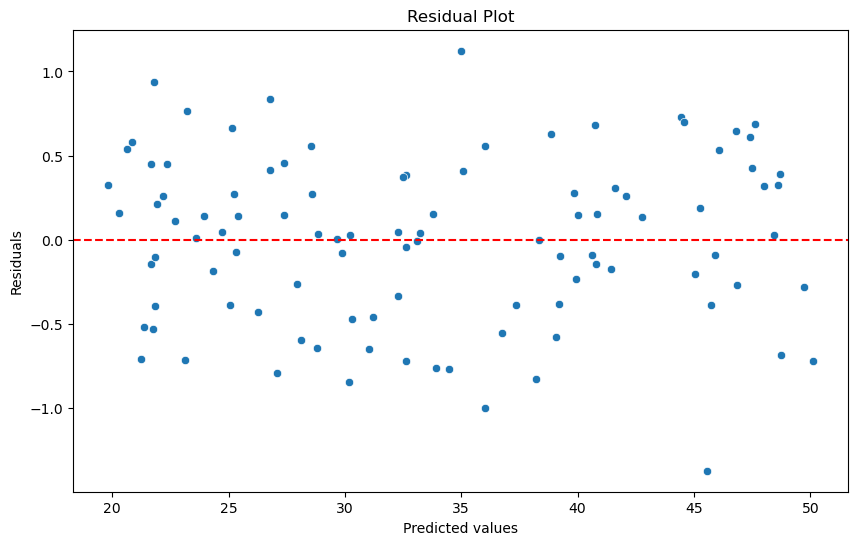

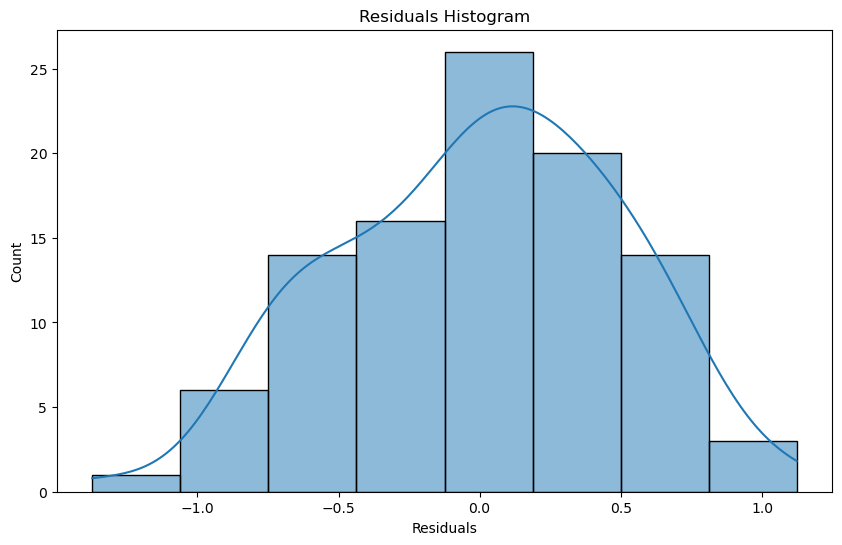

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict the values using the fitted multiple regression model
y_pred = model.predict(sm.add_constant(X_with_intercept))

# Calculate residuals
residuals = y - y_pred

# Plot residuals
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

# Check histogram for normality
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.show()


Outliers in the dataset:
Empty DataFrame
Columns: [Project_ID, Building_Height, Material_Quality_Index, Labor_Cost, Concrete_Strength, Foundation_Depth, Weather_Index, Construction_Cost]
Index: []


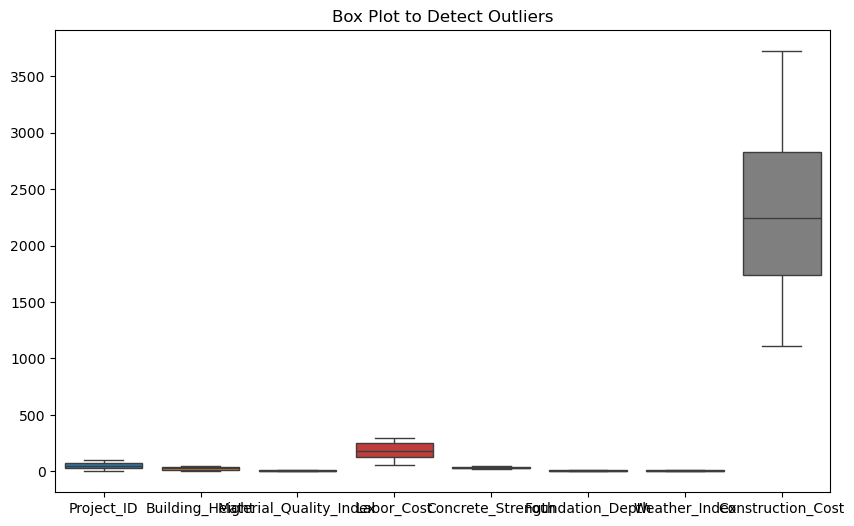

In [21]:
import numpy as np

# Calculate Z-scores
z_scores = np.abs((X - X.mean()) / X.std())

# Identify outliers based on Z-scores (threshold = 3)
outliers = (z_scores > 3).any(axis=1)
outlier_data = df[outliers]

print("Outliers in the dataset:")
print(outlier_data)

# Alternatively, use a box plot
plt.figure(figsize=(10,6))
sns.boxplot(data=df)
plt.title('Box Plot to Detect Outliers')
plt.show()
